In [1]:
#Setup
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import time

In [2]:
#Code from homeworks 3 & 4

#Calculate square distances -- should be correct
def calcSqDistances(X, Kmus):
    N, D = X.shape
    Out = np.zeros((N, Kmus.shape[0]), dtype = float) # Shape: (N, 4)
    for i in range(N): 
        for j in range(Kmus.shape[0]): 
            Out[i][j] = np.linalg.norm(X[i] - Kmus[j])**2
    return Out


#Determine R_nk -- should be correct
def determineRnk(sqDmat):
    N, K = sqDmat.shape
    Out = np.zeros((N,K))
    
    for i in range(N):
        m = np.argmin(sqDmat[i])
        Out[i,m] = 1       
    return Out


#Recalculate Mus -- still looking over
# def recalcMus(X, Rnk):
#     N, D = X.shape     # Shape: (N, 16)
#     N, J = Rnk.shape   # Shape: (N, K)
#     Kmus = np.zeros((J,D), dtype = float)   # Shape: (K, D)
    
#     # For each cluster
#     for i in range(J):
#         topTotal = 0
#         botTotal = 0
#         # For each datapoint
#         for j in range(N):
#             top = np.dot(Rnk[j,i], X[j])
#             bot = Rnk[j,i]
#             topTotal += top 
#             botTotal += bot
# #             print(f"Top total: {topTotal}")
# #             print(f"Bot total: {botTotal}")
#             value = topTotal / botTotal
            
#         Kmus[i,:] = value         
            
#     return Kmus

# recalculates mu values based on cluster assignments
# returns a 2-D numpy array consisting of the coordinates of the new clusters
def recalcMus(X, Rnk):
    Kmus = np.zeros((Rnk.shape[1], X.shape[1])) # shape: (K, 16)
    n_count = [0]*Rnk.shape[1]                  # counts the number of data points in each cluster
    
    for k in range(Rnk.shape[1]): # iterates over k clusters
        # at each index of the responsibility matrix, check if data point i is in cluster k
        # sums datapoints belonging to cluster k, and increments counter to track how many data points are in cluster k
        for i in range(len(X)):
            if Rnk[i][k] == 1:
                Kmus[k] = np.add(Kmus[k], X[i])
                n_count[k] += 1
            else:
                continue
    for i in range(len(Kmus)):
        Kmus[i] = np.divide(Kmus[i], n_count[i])
    return Kmus

#Provided function - plotCurrent
def plotCurrent(X, Rnk, Kmus):
    N, D = X.shape
    K = Kmus.shape[0]

    InitColorMat = np.array([[1, 0, 0],
                             [0, 1, 0],
                             [0, 0, 1],
                             [0, 0, 0],
                             [1, 1, 0],
                             [1, 0, 1],
                             [0, 1, 1]])

    KColorMat = InitColorMat[0:K,:]

    colorVec = np.dot(Rnk, KColorMat)
    muColorVec = np.dot(np.eye(K), KColorMat)
    plt.scatter(X[:,0], X[:,1], c=colorVec)

    plt.scatter(Kmus[:,0], Kmus[:,1], s=200, c=muColorVec, marker='d')
    plt.axis('equal')
    plt.show()

#Provided function - runKMeans
def runKMeans(K,X):
    #load data file specified by fileString from Bishop book
#     X = np.loadtxt(fileString, dtype='float')

    #determine and store data set information
    N, D = X.shape

    #allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    #initialize cluster centers by randomly picking points from the data
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K],:]

    #specify the maximum number of iterations to allow
    maxiters = 1000

    for iter in range(maxiters):
        #assign each data vector to closest mu vector as per Bishop (9.2)
        #do this by first calculating a squared distance matrix where the n,k entry
        #contains the squared distance from the nth data vector to the kth mu vector

        #sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus)

        #given the matrix of squared distances, determine the closest cluster
        #center for each data vector

        #R is the "responsibility" matrix
        #R will be an N-by-K matrix of binary values whose n,k entry is set as
        #per Bishop (9.2)
        #Specifically, the n,k entry is 1 if point n is closest to cluster k,
        #and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus
        time.sleep(1)

        #recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)

        #check to see if the cluster centers have converged.  If so, break.
        if np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1)))) < 1e-6:
#             print(iter)
            break

    return Kmus

#Sambaran's gaussian function from Discussion
def gaussian(x, mu, cov):
    l,m = np.shape(cov)
    constant = .001*np.identity(l)
    cov = cov+constant
    d = np.shape(x)[1]
    mu = mu[None, :]
    dr = 1 / (np.sqrt((2 * np.pi) ** (d) * np.linalg.det(cov)))
    nr = (np.exp(-np.diag((x - mu)@(np.linalg.pinv(cov))@((x - mu).T)/2)))
    
    return nr * dr

#Calculate responsibility
# def calcRespons(x, pi, mu, cov):
    
#     top = np.zeros((x.shape[0], 2))
#     for i in range(2):
#         top[:,i] = pi[i] * gaussian(x, mu[i], np.diag(cov[i]))
#     bot = np.sum(top, axis = 1, keepdims = True)
#     return np.divide(top, bot)

def calcRespons(X, N, K, pi, mu, sigma):
    respons = np.zeros((N, K), dtype=float)
    for cluster in range(K):
        respons[:, cluster] = gaussian(X, mu[cluster], sigma[cluster]) * pi[cluster]
    
    respons = np.divide(respons, np.sum(respons, axis=1, keepdims=True))
    
    return respons
    
#Tweaking runKMeans to get runGMM
def runGMM(K,X, pi_in, mu_in, var_in):
    N, D = X.shape
    
    mu = mu_in
    pi = pi_in
    var = var_in

    #100 maximum iterations
    maxiters = 10
    for iter in range(maxiters):        
        print(f"Current iter: {iter}")
        #Get gamma using calcRespons
        print(f"Pi: {pi}", "\n")
        print(f"Mu: {mu}", "\n")
        print(f"Var: {var}", "\n")
        gamma = calcRespons(X, N, K, pi, mu, var)
#         print(f"Passed gamma @ iter: {iter}")
        
        # Plot current iter
        plotCurrent(X, gamma, mu)
        
        #Determine pi using gamma
        new_pi = np.sum(gamma, axis=0) / N
#         print(f"Passed pi @ iter: {iter}")
        
        #Determine mus
        new_mu = np.divide(gamma.T @ X, np.sum(gamma, axis=0, keepdims=True).T) 
#         print(f"Passed mu @ iter: {iter}")
        
        #Determine variances       
        temp_var = np.zeros((K,D)) 
        for cluster in range(K):
            temp_var[cluster] = np.divide(gamma[:,cluster].T @ ((X - new_mu[cluster])*((X - new_mu[cluster]))), np.sum(gamma[:,cluster]))
    
        new_var = np.zeros((K, D, D))
        for i in range(K):
            new_var[i] = np.diag(temp_var[i])
            
        #check to see if the cluster centers have converged.  If so, break.
        if np.sum(np.abs(new_mu.reshape((-1, 1)) - mu.reshape((-1, 1)))) < 1e-2:
            print(iter)
            plotCurrent(X, gamma, mu)
            break
                
        mu, pi, var = new_mu, new_pi, new_var
        
                
    return new_pi, new_mu, new_var

In [3]:
thing = pd.read_csv('Training_Set.csv', delimiter=',', header = None)
thing = np.asarray(thing, dtype = float)

In [4]:
test = thing[:10]

In [5]:
# Original code from notebook -- not using

# #Initialization parameters
# muOld = runKMeans(4, thing) 
# piKOld = np.asarray([1/4]*4)
# covOld = np.zeros((4,4))
# for i in range(len(covOld)):
#     covOld[i] = np.asarray([4,5])

# #Find GMM
# runGMM(4, thing, piOld, muOld, covOld)

In [8]:
thing.shape

(4000, 16)

Current iter: 0
Pi: [0.25 0.25 0.25 0.25] 

Mu: [[1.26207483e+01 8.56632653e+00 1.21556122e+01 1.77661565e+01
  5.57823129e+00 3.03061224e+00 6.37755102e-01 2.41496599e-01
  1.00340136e-01 2.63605442e-02 4.67687075e-02 3.40136054e-03
  4.25170068e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.07223427e+01 1.07982646e+01 1.33731020e+01 1.15433839e+01
  1.29522777e+01 1.38373102e+01 9.94143167e+00 6.17353579e+00
  3.76355748e+00 2.03145336e+00 1.02819957e+00 4.07809111e-01
  1.64859002e-01 6.29067245e-02 3.14533623e-02 2.16919740e-02]
 [1.16224215e+01 8.60717489e+00 1.30143498e+01 2.71121076e+00
  3.34080717e+00 9.60538117e-01 3.31838565e-01 8.78923767e-02
  2.24215247e-02 2.51121076e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.35209657e+01 2.43214740e+01 1.04993647e+01 8.45362135e+00
  8.39008895e+00 3.00762389e+00 1.19949174e+00 4.43456163e-01
  9.91105464e-02 5.84498094e-02 1.14358323e-02 2.41423126e-02
  0.00000000e+00 0.

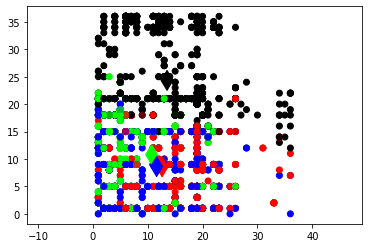

Current iter: 1
Pi: [0.27963199 0.21908219 0.27799806 0.22328776] 

Mu: [[1.41418717e+01 7.70338468e+00 1.20219576e+01 1.76338669e+01
  5.77676630e+00 3.45464904e+00 1.23907605e+00 4.51914439e-01
  3.43398380e-01 1.95092009e-01 2.08771392e-01 5.25085946e-02
  3.61401699e-02 1.43043886e-02 5.49960837e-17 1.22213519e-16]
 [8.12873637e+00 1.10330968e+01 1.36181781e+01 1.16427504e+01
  1.32643750e+01 1.32286383e+01 8.69616792e+00 5.55699298e+00
  3.25213480e+00 1.76349888e+00 8.09550059e-01 3.51575569e-01
  1.17782559e-01 4.76286914e-02 3.25549632e-02 2.16277286e-02]
 [1.12073692e+01 8.06779450e+00 1.29156626e+01 3.07966051e+00
  3.63867987e+00 1.00752143e+00 4.39880322e-01 1.57797201e-01
  1.04079180e-01 3.74142872e-02 2.21640962e-02 5.55009802e-03
  1.20144143e-02 2.35388325e-04 4.23698879e-04 9.41553065e-04]
 [1.44700811e+01 2.40850684e+01 1.08111464e+01 8.80096539e+00
  7.49972636e+00 3.56365972e+00 1.94167982e+00 9.76653512e-01
  3.82046083e-01 1.93444294e-01 4.97173139e-02 2.91106703

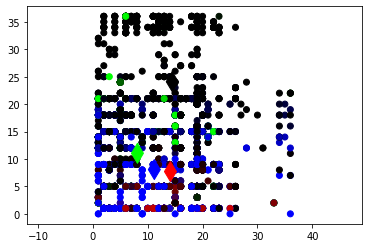

Current iter: 2
Pi: [0.05647202 0.06802085 0.28829698 0.58721016] 

Mu: [[1.26672507e+001 3.43463370e+000 1.39769975e+001 1.94523066e+001
  4.54364331e+000 4.45650471e+000 3.78406499e-001 2.49732602e-002
  1.30825211e-002 4.91450230e-003 1.83321764e-002 3.39374969e-012
  9.49203111e-032 4.98447713e-123 0.00000000e+000 0.00000000e+000]
 [1.09986635e+001 1.11897053e+001 1.37451873e+001 1.26541132e+001
  1.23926040e+001 1.24259172e+001 1.25129448e+001 1.05284308e+001
  1.20929173e+001 7.15895069e+000 3.70195298e+000 1.46646215e+000
  5.77028966e-001 2.13169936e-001 1.06584968e-001 7.35068746e-002]
 [1.17904880e+001 7.99741439e+000 1.25202959e+001 3.77976588e+000
  3.83590900e+000 3.89400985e-001 3.48474528e-002 1.82354143e-003
  4.43638332e-005 1.62213781e-028 3.59898116e-034 8.97581257e-218
  1.55977915e-256 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.22943281e+001 1.52096750e+001 1.19478825e+001 1.23534144e+001
  8.51837256e+000 6.35351346e+000 3.27811612e+000 1.51165844e+000
 

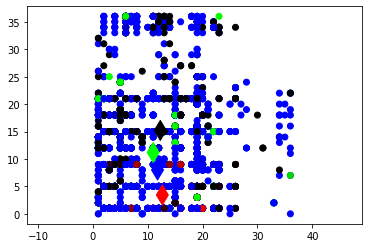

Current iter: 3
Pi: [0.04745123 0.06571105 0.61979545 0.26704227] 

Mu: [[1.33246852e+001 4.10753227e+000 1.45786551e+001 1.86300155e+001
  6.23215172e+000 1.24216316e+001 2.38734437e-001 8.38228838e-006
  1.08683198e-033 1.38279887e-243 5.53119550e-243 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.14074926e+001 1.13523825e+001 1.37292892e+001 1.26075387e+001
  1.18955945e+001 1.19010832e+001 1.12713041e+001 9.49053839e+000
  1.32218476e+001 7.52537101e+000 3.85018982e+000 1.51800962e+000
  5.97312057e-001 2.20663053e-001 1.10331526e-001 7.60907079e-002]
 [1.22863355e+001 1.23089631e+001 1.19499163e+001 8.63804050e+000
  5.14467314e+000 3.47640501e-001 1.61199555e-003 1.73240597e-071
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.15529055e+001 1.35636812e+001 1.25422284e+001 1.21205906e+001
  1.10149593e+001 1.25563628e+001 7.69362635e+000 3.67775628e+000
 

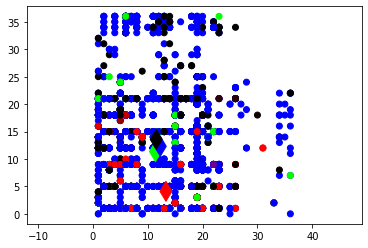

Current iter: 4
Pi: [0.10742147 0.06575022 0.628246   0.19858232] 

Mu: [[1.21298570e+001 7.60812403e+000 1.32813534e+001 1.30857539e+001
  8.91805311e+000 1.52260010e+001 1.31086433e-001 9.78382513e-220
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.14220769e+001 1.13497907e+001 1.37300558e+001 1.26083622e+001
  1.18897393e+001 1.19011501e+001 1.12699424e+001 9.48669014e+000
  1.32205148e+001 7.52088732e+000 3.84789584e+000 1.51710518e+000
  5.96956173e-001 2.20531580e-001 1.10265790e-001 7.60453723e-002]
 [1.22696477e+001 1.24128652e+001 1.20348443e+001 9.08667993e+000
  5.11960232e+000 2.85325537e-001 6.40496740e-081 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.16809587e+001 1.42517226e+001 1.23850433e+001 1.18824086e+001
  1.13372986e+001 1.17968347e+001 1.03353479e+001 4.94504271e+000
 

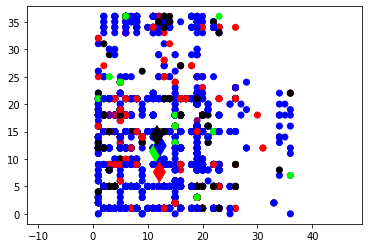

Current iter: 5
Pi: [0.15267935 0.06574599 0.61107636 0.1704983 ] 

Mu: [[1.20093797e+001 1.12796975e+001 1.26835655e+001 1.24811871e+001
  9.68331061e+000 1.43339341e+001 9.00624684e-002 1.08569353e-225
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.14214241e+001 1.13499345e+001 1.37302405e+001 1.26083644e+001
  1.18898326e+001 1.19009669e+001 1.12700998e+001 9.48664031e+000
  1.32206674e+001 7.52137070e+000 3.84814315e+000 1.51720268e+000
  5.96994540e-001 2.20545753e-001 1.10272877e-001 7.60502598e-002]
 [1.22975316e+001 1.23708687e+001 1.20119653e+001 9.03413191e+000
  4.85648153e+000 1.43088421e-001 3.98185522e-216 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.16292775e+001 1.26925899e+001 1.27291308e+001 1.20111850e+001
  1.16110749e+001 1.10360362e+001 1.20399171e+001 5.75983100e+000
 

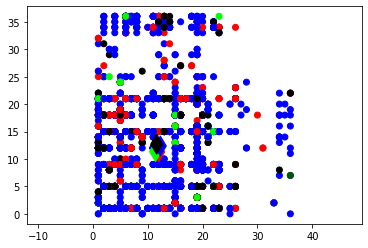

Current iter: 6
Pi: [0.16783    0.06541087 0.59641819 0.17034093] 

Mu: [[1.19061084e+001 1.17906602e+001 1.27028594e+001 1.22228441e+001
  1.00699115e+001 1.34866135e+001 8.04297063e-002 3.82601766e-236
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.13773040e+001 1.13588718e+001 1.37500162e+001 1.26091937e+001
  1.18931518e+001 1.18847907e+001 1.12813763e+001 9.47841834e+000
  1.32319676e+001 7.55990524e+000 3.86785850e+000 1.52497583e+000
  6.00053146e-001 2.21675685e-001 1.10837842e-001 7.64398912e-002]
 [1.23286522e+001 1.22961385e+001 1.19887414e+001 9.02112887e+000
  4.64973448e+000 3.35601457e-002 2.03717756e-221 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.16622935e+001 1.25427224e+001 1.27281506e+001 1.20141194e+001
  1.15435499e+001 1.10315892e+001 1.20703627e+001 5.78697310e+000
 

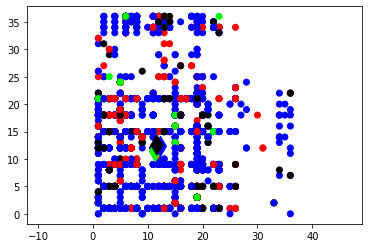

Current iter: 7
Pi: [0.18766846 0.06490884 0.57657849 0.17084421] 

Mu: [[1.17947260e+001 1.19692383e+001 1.26508933e+001 1.21498380e+001
  1.04129990e+001 1.21668106e+001 7.19198757e-002 8.36110820e-240
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.13391989e+001 1.13647050e+001 1.37791997e+001 1.26205207e+001
  1.18827999e+001 1.18589197e+001 1.12808782e+001 9.49865048e+000
  1.32439871e+001 7.61837718e+000 3.89777437e+000 1.53677073e+000
  6.04694245e-001 2.23390231e-001 1.11695115e-001 7.70311140e-002]
 [1.23794479e+001 1.22554191e+001 1.19810828e+001 8.93471420e+000
  4.35156225e+000 2.21086704e-004 3.09549266e-316 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.16759256e+001 1.25369809e+001 1.27200672e+001 1.20115937e+001
  1.15484896e+001 1.10439635e+001 1.20681536e+001 5.79009157e+000
 

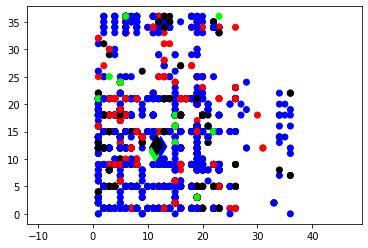

Current iter: 8
Pi: [0.18777478 0.06407878 0.57647057 0.17167586] 

Mu: [[1.17949667e+001 1.19705398e+001 1.26522849e+001 1.21478702e+001
  1.04120203e+001 1.21604568e+001 7.18703417e-002 2.14271340e-242
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.13402634e+001 1.14006205e+001 1.38031127e+001 1.26826575e+001
  1.18249003e+001 1.17862894e+001 1.12846340e+001 9.53837824e+000
  1.32569350e+001 7.71706269e+000 3.94826463e+000 1.55667746e+000
  6.12527221e-001 2.26283942e-001 1.13141971e-001 7.80289453e-002]
 [1.23794833e+001 1.22550517e+001 1.19804995e+001 8.93474426e+000
  4.35073938e+000 8.27381719e-176 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.16738868e+001 1.25178922e+001 1.27162773e+001 1.19913766e+001
  1.15717298e+001 1.10750676e+001 1.20628427e+001 5.79314000e+000
 

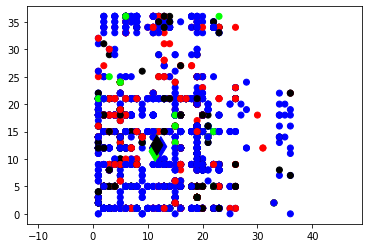

Current iter: 9
Pi: [0.18777258 0.05391974 0.57647327 0.18183441] 

Mu: [[1.17949634e+001 1.19705557e+001 1.26523025e+001 1.21478664e+001
  1.04119672e+001 1.21606397e+001 7.18737867e-002 2.32597191e-242
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.11948664e+001 1.19159684e+001 1.35392367e+001 1.26948277e+001
  1.21492854e+001 1.19400229e+001 1.11576792e+001 9.98515117e+000
  1.31072452e+001 9.17103848e+000 4.69215922e+000 1.84997187e+000
  7.27933792e-001 2.68918216e-001 1.34459108e-001 9.27304194e-002]
 [1.23794798e+001 1.22550457e+001 1.19804982e+001 8.93476347e+000
  4.35078705e+000 3.72871512e-215 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.16983678e+001 1.23026534e+001 1.28552426e+001 1.20263797e+001
  1.14896807e+001 1.10692051e+001 1.20570408e+001 5.86991895e+000
 

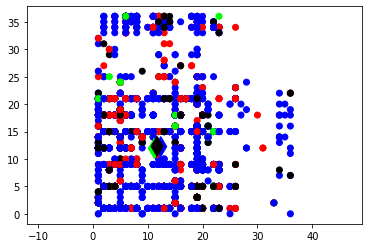

(array([0.18777463, 0.04075002, 0.57647328, 0.19500207]),
 array([[1.17949401e+001, 1.19705642e+001, 1.26523148e+001,
         1.21478954e+001, 1.04120016e+001, 1.21606789e+001,
         7.18837683e-002, 4.64705949e-242, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000],
        [1.18098109e+001, 1.21288323e+001, 1.40920226e+001,
         1.24907957e+001, 1.23067478e+001, 1.21533694e+001,
         1.12147202e+001, 1.06503111e+001, 1.13435674e+001,
         1.21349622e+001, 6.20858532e+000, 2.44785133e+000,
         9.63189620e-001, 3.55828012e-001, 1.77914006e-001,
         1.22699315e-001],
        [1.23794798e+001, 1.22550456e+001, 1.19804982e+001,
         8.93476350e+000, 4.35078715e+000, 3.72911617e-215,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.000

In [9]:
#Initialization parameters
muOld = runKMeans(4, thing) 
piOld = np.asarray([1/4]*4)
# covOld = np.zeros((4,4))
N, D = thing.shape
covOld = np.zeros((4, D, D))
d = []
for i in range(1,17):
    d.append(i)

for i in range(4):
    covOld[i] = np.diag(d)

#Find GMM
runGMM(4, thing, piOld, muOld, covOld)